## Importing Libraries

In [0]:
import os
import numpy as np
import pandas as pd
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt
%matplotlib inline
import sys

import cv2
import time

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K

from sklearn.utils import shuffle

import numpy.random as random

## Importing Dataset

In [2]:
!git clone https://github.com/pantherofficial404/Omniglot-Dataset.git

Cloning into 'Omniglot-Dataset'...
remote: Enumerating objects: 34136, done.
remote: Counting objects: 100% (34136/34136), done.
remote: Compressing objects: 100% (34136/34136), done.
remote: Total 34136 (delta 0), reused 34136 (delta 0), pack-reused 0
Receiving objects: 100% (34136/34136), 8.99 MiB | 11.06 MiB/s, done.
Checking out files: 100% (32460/32460), done.


In [3]:
!ls Omniglot-Dataset

images_background  images_evaluation


## Loading Dataset

In [0]:
def preprocessImages(path):
    X = []
    y = []
    languageDictionary = {}
    currentY = 0
    print("Loading and Preprocess Data")
    for alphabet in os.listdir(path):
        languageDictionary[alphabet] = [currentY,None]
        alphabetPath = os.path.join(path,alphabet)
        print(alphabet+" Loaded")
        for letter in os.listdir(alphabetPath):
            images=[]
            letterPath = os.path.join(alphabetPath, letter)
            
            for filename in os.listdir(letterPath):
                imagePath = os.path.join(letterPath, filename)
                image = imread(imagePath)
                images.append(image)
                y.append(currentY)
            X.append(np.stack(images))
            currentY += 1
            languageDictionary[alphabet][1] = currentY - 1
    y = np.vstack(y)
    X = np.stack(X)
    print("Loading Completed")
    return X,y,languageDictionary

In [78]:
Xtrain,Ytrain,trainCategory = preprocessImages('Omniglot-Dataset/images_background')
Xval,Yval,validationCategory=preprocessImages("Omniglot-Dataset/images_evaluation")

Loading and Preprocess Data
Japanese_(katakana) Loaded
Japanese_(hiragana) Loaded
Tifinagh Loaded
Sanskrit Loaded
Hebrew Loaded
Korean Loaded
N_Ko Loaded
Ojibwe_(Canadian_Aboriginal_Syllabics) Loaded
Braille Loaded
Tagalog Loaded
Bengali Loaded
Inuktitut_(Canadian_Aboriginal_Syllabics) Loaded
Blackfoot_(Canadian_Aboriginal_Syllabics) Loaded
Grantha Loaded
Syriac_(Estrangelo) Loaded
Balinese Loaded
Latin Loaded
Burmese_(Myanmar) Loaded
Early_Aramaic Loaded
Alphabet_of_the_Magi Loaded
Armenian Loaded
Mkhedruli_(Georgian) Loaded
Asomtavruli_(Georgian) Loaded
Cyrillic Loaded
Anglo-Saxon_Futhorc Loaded
Greek Loaded
Gujarati Loaded
Arcadian Loaded
Malay_(Jawi_-_Arabic) Loaded
Futurama Loaded
Loading Completed
Loading and Preprocess Data
Glagolitic Loaded
Avesta Loaded
Atemayar_Qelisayer Loaded
Keble Loaded
Atlantean Loaded
Tibetan Loaded
ULOG Loaded
Gurmukhi Loaded
Mongolian Loaded
Oriya Loaded
Malayalam Loaded
Syriac_(Serto) Loaded
Sylheti Loaded
Aurek-Besh Loaded
Ge_ez Loaded
Old_Church_Sl

## Getting Data On Batches

In [0]:
def getBatch(batchSize,mode="train"):
  
#   Setting Up Mode
    if mode == 'train':
        X = Xtrain
        categories = trainCategory
    else:
        X = Xval
        categories = validationCategory
        
    numberOfClasses, numberOfExamples, width, height = X.shape
    
    categories = random.choice(numberOfClasses,size=(batchSize,),replace=False)
    
    pairs = [np.zeros((batchSize, height, width,1)) for i in range(2)]
    
    targets = np.zeros((batchSize,))
    
#     Half Target should have value of 1 and another half targets value should have 0

    targets[batch_size//2:] = 1
  
    for i in range(batchSize):
      
        image1Category = categories[i]
        
        image1Index = random.randint(0, numberOfExamples)
        pairs[0][i,:,:,:] = X[image1Category, image1Index].reshape(height, width, 1)
        
        image2Index = random.randint(0, numberOfExamples)

        if i >= batchSize // 2:
            image2Category = image1Category  #same Class
        else: 
            image2Category = (image1Category + random.randint(1,numberOfClasses)) % numberOfClasses # adding some noise for different Class 
        
        pairs[1][i,:,:,:] = X[image2Category,image2Index].reshape(height, width,1)
    
    return pairs, targets

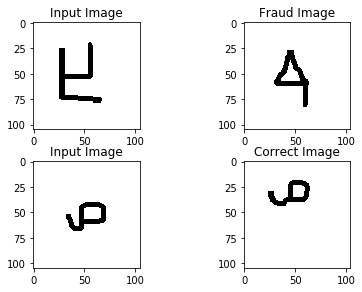

In [217]:
# Testing The Batch Generator Function
fig, ax = plt.subplots(nrows=2, ncols=2)
plt.tight_layout()
pairs,targets = getBatch(10)
ax[0][0].imshow(pairs[0][1].reshape(105,105),cmap="gray")
ax[0][0].set_title("Input Image")
ax[0][1].imshow(pairs[1][1].reshape(105,105),cmap="gray")
ax[0][1].set_title("Fraud Image")
ax[1][0].imshow(pairs[0][5].reshape(105,105),cmap="gray")
ax[1][0].set_title("Input Image")
ax[1][1].imshow(pairs[1][5].reshape(105,105),cmap="gray")
ax[1][1].set_title("Correct Image")
plt.show()

In [0]:
# Generator that provides pairs of images along with targets while training the neural network
def generate(batchSize, mode="train"):
    while True:
        pairs, targets = getBatch(batchSize,mode)
        yield (pairs, targets)

In [0]:
def makeOneShotTask(N, mode="val", language=None):
    if mode == 'train':
        X = Xtrain
        categories = trainCategory
    else:
        X = Xval
        categories = validationCategory
    
    numberOfClasses, numberOfExamples, width, height = X.shape
    
    indices = rng.randint(0, numberOfExamples,size=(N,))
    
    if language is not None:
        low, high = categories[language]
        if N > high - low:
            raise ValueError("This language ({}) has less than {} letters".format(language, N))
        categories = random.choice(range(low,high),size=(N,),replace=False)

    else:
        categories = random.choice(range(numberOfClasses),size=(N,),replace=False) 
        
    true_category = categories[0]
    ex1, ex2 = random.choice(numberOfExamples,replace=False,size=(2,))
    test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, width,height,1)
    support_set = X[categories,indices,:,:]
    support_set[0,:,:] = X[true_category,ex2]
    support_set = support_set.reshape(N, width,height,1)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image,support_set]

    return pairs, targets

In [0]:
pairs,targets = makeOneShotTask(3,"train","Gujarati")

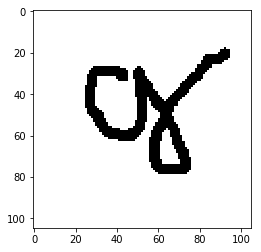

(3,)
2


In [208]:
plt.imshow(pairs[1][0].reshape(105,105),cmap="gray")
plt.show()
print(targets.shape)
print(len(pairs))

In [0]:
# Initialize the Weights
def initialize_weights(shape, name=None):
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)
  
def initialize_bias(shape, name=None):
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

## Model Architecture

In [215]:
def get_siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net
  
model = get_siamese_model((105, 105, 1))
model.summary()
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 4096)         38947648    input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 4096)         0           sequential_5[1][0]               
          

## Accuracy Checking

In [0]:
def testOneshot(model, N, nVal, mode = "val"):
    n_correct = 0
    for i in range(nVal):
        inputs, targets = makeOneShotTask(N,mode)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct+=1
    percent_correct = (100.0 * n_correct / k)
    return percent_correct

In [0]:
evalutionEvery = 200
batchSize = 32
numberOfIteration = 20000
nWay = 16 
nVal = 250 
bestAccuracy = -1

## Training The Siamese Network

In [0]:
for i in range(1, numberOfIteration+1):
    (inputs,targets) = getBatch(batchSize)
    loss = model.train_on_batch(inputs, targets)
    if i % evalutionEvery == 0:
      print("Iteration"+i)
      print("Train Loss: {0}".format(loss)) 
      val_acc = testOneShot(model, N_way, nVal)
      if val_acc >= best:
          print("Current best: {0}, previous best: {1}".format(val_acc, best))
          best = val_acc